#Football matches from AUF page


#1.- Introduction
In this notebook, we'll obtain the matches results of the National Team from the official AUF page, as well as the teams playing in each match, the result, datetime and the venue to be held. Below, there's a preview of the homepage.

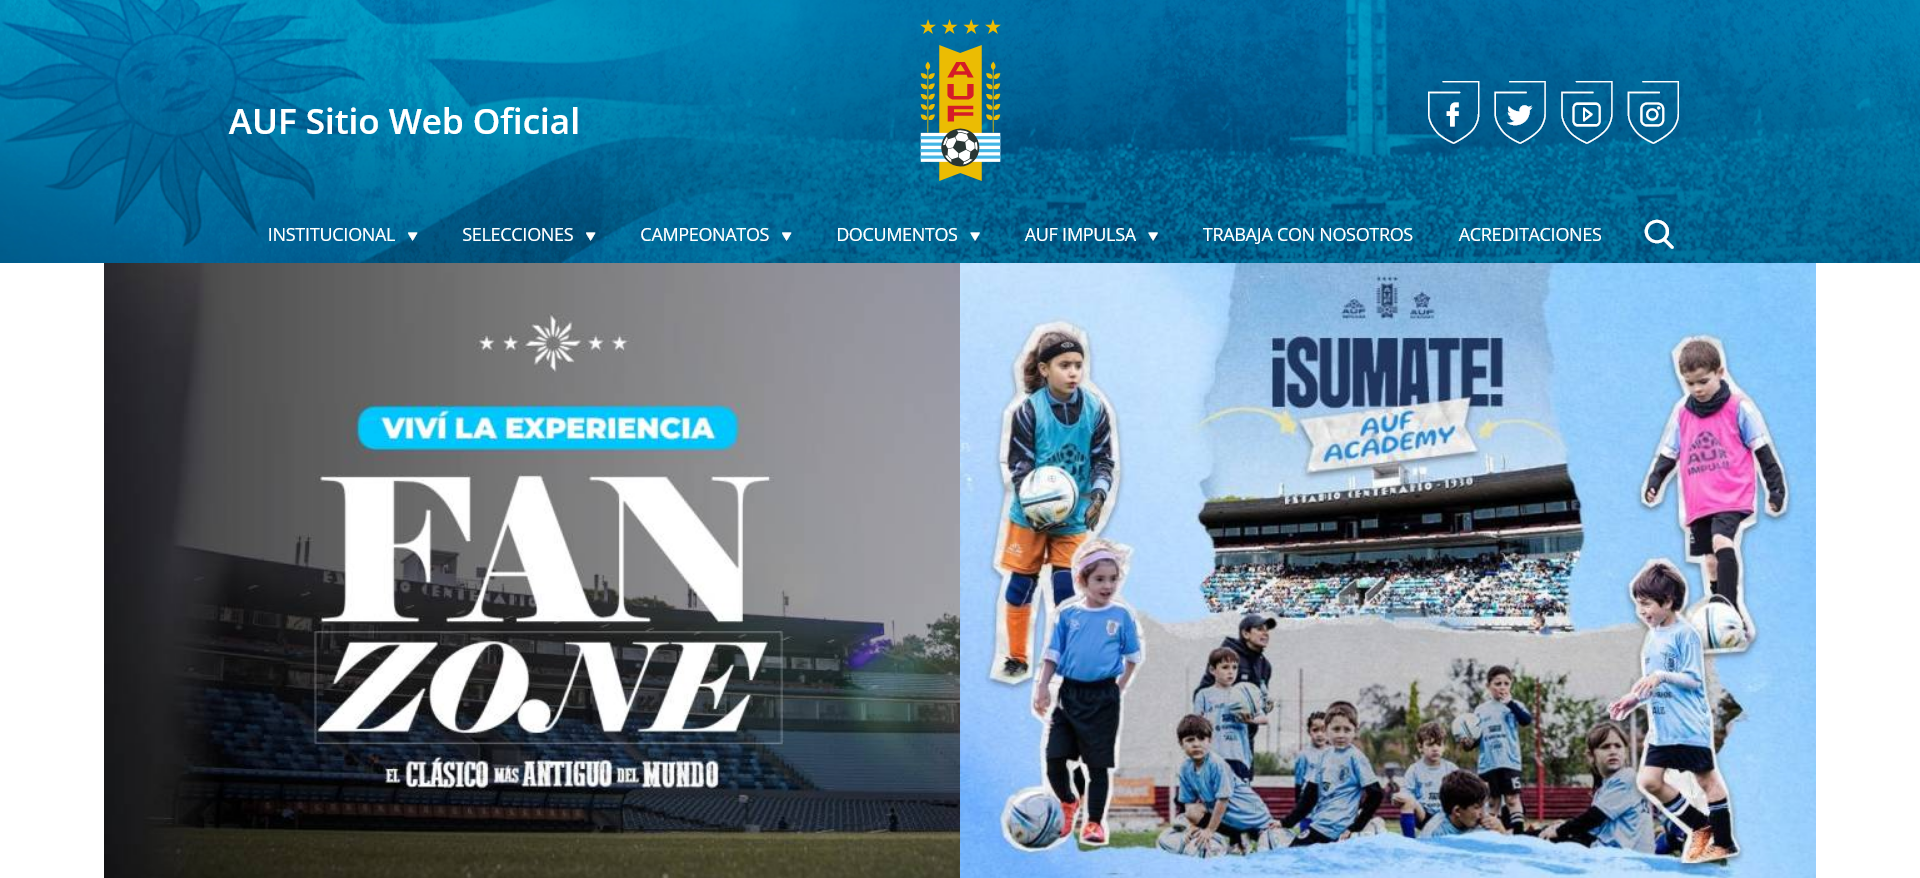

#2.- Source
We are going to scrape the official Uruguayan Football Association (AUF):
[www.auf.org.uy/](https://https://www.auf.org.uy/).
The AUF site displays the fixture of matches to be held between all its associated teams and  managed cups, as well as the historic data from all the tournaments it regulates.


##2.1.- National Team
All the info about national team is below the _SELECCIONES_ tab.

# 3.- Setup and library imports
We'll be using BeautifulSoup, as this webpage doesn't require login and the results are shown in the page html structure.

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
from datetime import date as d

#4.- National Team matches
This section is dedicated to scraping match results related to national teams from the AUF website.

Once we go under the _SELECCIONES_ tab, we can find all the historic of matches held in these three categories:
* Major
* Olympic
* U-20 (under-20)

Once we choose each of the three categories, we can see that the url changes as follows:

* Major [https://www.auf.org.uy/historico-partidos/1/](https://www.auf.org.uy/historico-partidos/1/)
* Olympic [https://www.auf.org.uy/historico-partidos/21/](https://www.auf.org.uy/historico-partidos/21/)
* U-20 (under-20) [https://www.auf.org.uy/historico-partidos/2/](https://www.auf.org.uy/historico-partidos/2/)




This give us a clue about the page layout (**1** for major, **21** for Olympic, **2** for U-20), where we can access each team data with a different url.

On each team we can filter the matches by date range, opponent and tournament type.

If we apply a filter to get the data, we can find the url changes in this way:

[https://www.auf.org.uy/historico-partidos/1/01_01_2024-31_12_2024-Amistoso-0-0/](https://www.auf.org.uy/historico-partidos/1/01_01_2024-31_12_2024-Amistoso-0-0/)

We can guess:
* _\1\_ is the Major team, as we saw earlier,
* _01_01_2024_ is the date range start ,
* _31_12_2024_ is the date range end,
* _Amistoso_ is the tournament type, being literally the tournament name (this will be a matter to set up if we want to explore some tournaments)
* _-0-_ is to see all the matches against a certain opponent

So we can access directly to data if we know the combination of url parameters we need to pass.

In general,

[https://www.auf.org.uy/historico-partidos/  _team_category_  /  _DateRangeStart_  -  _DateRangeEnd_  -  _TournamentType-Opponent_  -0/](https://www.auf.org.uy/historico-partidos/1/)

##4.1.- Creating custom URL to scrape

The function below constructs a URL based on input parameters such as team category, date range, tournament type, and opponent.

In [ ]:
def build_url(team_cat,date_range_start,date_range_end,tournament_type='',opponent=0):
  # Construct the URL using provided parameters
  base_url = f"https://www.auf.org.uy/historico-partidos/"
  params = f"{team_cat}/{date_range_start}-{date_range_end}-{tournament_type}-{opponent}-0/"
  url = base_url + params
  return url

def input_team_cat():
  cat = input("Select a team: 1:Major, 21:Olympic, 2:U-20: ")
  if cat in ['1','21','2']:
    return cat
  else:
    print("Invalid category, try again.")
    return input_team_cat()

def input_date_range(notice):
  current_year = d.today().year #get this year just to prevent accessing future dates
  print(notice)
  date = input("Enter the date in the format DD_MM_YYYY: ")
  date_parts = date.split('_') #we get the input into a list we the first element is the day, second for the month, and last for the year
  pattern = re.compile(r'^\d{2}_\d{2}_\d{4}$')
  try:
    if len(date_parts) != 3 or 1>int(date_parts[0])>31 or 1>int(date_parts[1])>12 or 1930>int(date_parts[2])>current_year:
      print("Invalid date format, try again.")
      return input_date_range(notice)
    if not pattern.match(date):
        print("Please, enter the date in the format DD_MM_YYYY, like 28_01_2007")
        return input_date_range(notice)
  except (ValueError, TypeError):
    print("Invalid date format, try again.")
    return input_date_range(notice)
  return date

##4.2. Usage of URL builder - example
Below is an example of how to use the `build_url` function. (This cell uses hardcoded values for demonstration).

In [ ]:
# Example usage of the build_url function
url = build_url('1', '01_01_2024', '31_12_2024')
print('Scraping URL:', url)

Scraping URL: https://www.auf.org.uy/historico-partidos/1/01_01_2024-31_12_2024--0-0/


## 4.3. Input functions for dynamic scraping

These functions prompt the user for input parameters such as team category and date range.

In [ ]:
# Function to scrape match data from the given URL
def scrape_matches(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        return []
    else:
      soup = BeautifulSoup(response.content, 'html.parser')
      return soup

soup = scrape_matches(
    build_url(input_team_cat(),
          input_date_range("Enter the date range start in the format DD_MM_YYYY: "),
          input_date_range("Enter the date range end in the format DD_MM_YYYY: "),
          tournament_type='', # '' means we want all tournaments
          opponent=0         # 0 means we want all oppponents
            )
    )

Select a team: 1:Major, 21:Olympic, 2:U-20: 1
Enter the date range start in the format DD_MM_YYYY: 
Enter the date in the format DD_MM_YYYY: 01_01_2024
Enter the date range end in the format DD_MM_YYYY: 
Enter the date in the format DD_MM_YYYY: 31_12_2024


In [ ]:
def soup2df(soup):
  menu = soup.select("section.cont-jugador-partidos mt-lg mb-lg")
  partidos = soup.select("div.cont-partidos")
  for match_ in partidos:
    partido = match_.find_all("div", class_ ="partido")
  op1 =[]
  op2 =[]
  fecha = []
  copa = []
  res = []
  venue = []
  for opp in partido:
    fecha.append(opp.find("strong").text)
    copa.append(opp.find("p").text)
    opp1 = opp.find_all("div",class_ = "pais pais-01")
    opp2 = opp.find_all("div",class_ = "pais pais-02")
    venue1 = opp.find_all("div",class_ = "col-12 col-lg-3 col-md-3 order-3 order-lg-3 order-md-3 col_estadio")
    for venue_ in venue1:
      venue.append(venue_.find("p").text)
    re_ = opp.find_all("div",class_ = "resultados")
    for re_ in re_:
      res.append(re_.find("p").text.strip().split("\n")[0])
    for op in opp1:
      op1.append(op.find("p").text)
    for op in opp2:
      op2.append(op.find("p").text)

  # create the dataframe and fill with the scraped columns
  matches =pd.DataFrame(columns=["Date","Cup","Team1","Team2","Score","Venue"])
  matches["Date"] = fecha
  matches["Cup"] = copa
  matches["Team1"] = op1
  matches["Team2"] = op2
  matches["Score"] = res
  matches["Venue"] = venue
  if len(matches)==0:
    return "There are no matches for this search."
  else:
    return matches

In [ ]:
matches = soup2df(soup)
print("Scraped matches:",len(matches))
matches

Scraped matches: 15


,Date,Cup,Team1,Team2,Score,Venue
0,19/11/2024 - 21:45,Eliminatorias Mundial de la FIFA 2026,Brasil,Uruguay,1 - 1,"Estádio Fonte Nova, Salvador, Bahia, Brasil"
1,15/11/2024 - 21:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Colombia,3 - 2,"Estadio Centenario, Montevideo, Uruguay"
2,15/10/2024 - 20:30,Eliminatorias Mundial de la FIFA 2026,Uruguay,Ecuador,0 - 0,"Estadio Centenario, Montevideo"
3,11/10/2024 - 22:30,Eliminatorias Mundial de la FIFA 2026,Perú,Uruguay,1 - 0,"Estadio Nacional José Díaz, Lima, Perú"
4,10/09/2024 - 19:00,Eliminatorias Mundial de la FIFA 2026,Venezuela,Uruguay,0 - 0,"Estadio Monumental, Maturín, Venezuela"
5,06/09/2024 - 20:30,Eliminatorias Mundial de la FIFA 2026,Uruguay,Paraguay,0 - 0,"Estadio Centenario, Montevideo, Uruguay"
6,13/07/2024 - 21:00,CONMEBOL Copa América USA 2024,Canadá,Uruguay,(3) 2 - 2 (4),"Bank of America, Charlotte, Estados Unidos"
7,10/07/2024 - 21:00,CONMEBOL Copa América USA 2024,Uruguay,Colombia,0 - 1,"Bank of America, Charlotte, Estados Unidos"
8,06/07/2024 - 22:00,CONMEBOL Copa América USA 2024,Uruguay,Brasil,(4) 0 - 0 (2),"Allegiant Stadium Nevada, Las Vegas, Estados U..."
9,01/07/2024 - 22:00,CONMEBOL Copa América USA 2024,Estados Unid...,Uruguay,0 - 1,"Arrowhead Stadium, Kansas City, Estados Unidos"


#5.Data cleaning and processing

This section handles data cleaning, such as converting date strings to datetime objects.

In [ ]:
def formatting_dates(col):
  try:
    formatted_col = pd.to_datetime(col, format='%d/%m/%Y - %H:%M')
  except ValueError:
    if type(col)!=str:
      formatted_col = pd.to_datetime(col.apply(lambda x: x.split(' ')[0]), format='%d/%m/%Y')
    else:
      formatted_col = col
  return formatted_col

matches["Date"] = formatting_dates(matches["Date"])
matches.head()

,Date,Cup,Team1,Team2,Score,Venue
0,2024-11-19 21:45:00,Eliminatorias Mundial de la FIFA 2026,Brasil,Uruguay,1 - 1,"Estádio Fonte Nova, Salvador, Bahia, Brasil"
1,2024-11-15 21:00:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Colombia,3 - 2,"Estadio Centenario, Montevideo, Uruguay"
2,2024-10-15 20:30:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Ecuador,0 - 0,"Estadio Centenario, Montevideo"
3,2024-10-11 22:30:00,Eliminatorias Mundial de la FIFA 2026,Perú,Uruguay,1 - 0,"Estadio Nacional José Díaz, Lima, Perú"
4,2024-09-10 19:00:00,Eliminatorias Mundial de la FIFA 2026,Venezuela,Uruguay,0 - 0,"Estadio Monumental, Maturín, Venezuela"


#6. Outputs examples

## 6.1. National matches in 2024

In [ ]:
soup1 = scrape_matches(
    build_url(team_cat='1',date_range_start='01_01_2024',date_range_end='31_12_2024',tournament_type='',opponent=0)
    )
national_matches_2024 = soup2df(soup1)
national_matches_2024['Date'] = formatting_dates(national_matches_2024['Date'])
national_matches_2024

,Date,Cup,Team1,Team2,Score,Venue
0,2024-11-19 21:45:00,Eliminatorias Mundial de la FIFA 2026,Brasil,Uruguay,1 - 1,"Estádio Fonte Nova, Salvador, Bahia, Brasil"
1,2024-11-15 21:00:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Colombia,3 - 2,"Estadio Centenario, Montevideo, Uruguay"
2,2024-10-15 20:30:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Ecuador,0 - 0,"Estadio Centenario, Montevideo"
3,2024-10-11 22:30:00,Eliminatorias Mundial de la FIFA 2026,Perú,Uruguay,1 - 0,"Estadio Nacional José Díaz, Lima, Perú"
4,2024-09-10 19:00:00,Eliminatorias Mundial de la FIFA 2026,Venezuela,Uruguay,0 - 0,"Estadio Monumental, Maturín, Venezuela"
5,2024-09-06 20:30:00,Eliminatorias Mundial de la FIFA 2026,Uruguay,Paraguay,0 - 0,"Estadio Centenario, Montevideo, Uruguay"
6,2024-07-13 21:00:00,CONMEBOL Copa América USA 2024,Canadá,Uruguay,(3) 2 - 2 (4),"Bank of America, Charlotte, Estados Unidos"
7,2024-07-10 21:00:00,CONMEBOL Copa América USA 2024,Uruguay,Colombia,0 - 1,"Bank of America, Charlotte, Estados Unidos"
8,2024-07-06 22:00:00,CONMEBOL Copa América USA 2024,Uruguay,Brasil,(4) 0 - 0 (2),"Allegiant Stadium Nevada, Las Vegas, Estados U..."
9,2024-07-01 22:00:00,CONMEBOL Copa América USA 2024,Estados Unid...,Uruguay,0 - 1,"Arrowhead Stadium, Kansas City, Estados Unidos"


## 6.2. U-20 matches in 2020

In [ ]:
soup2 = scrape_matches(
    build_url(team_cat='2',date_range_start='01_01_2020',date_range_end='31_12_2020',tournament_type='',opponent=0)
    )
U20_matches_2020 = soup2df(soup2)
U20_matches_2020

'There are no matches for this search.'

#6.3. Olympic matches since 1990

In [ ]:
soup3 = scrape_matches(
    build_url(team_cat='21',date_range_start='01_01_1990',date_range_end='31_12_2024',tournament_type='',opponent=0)
    )
Olympic_matches = soup2df(soup3)
Olympic_matches

,Date,Cup,Team1,Team2,Score,Venue
0,02/02/2024 - 20:00,CONMEBOL Preolímpico - Venezuela 2024,Argentina,Uruguay,3 - 3,"Polideportivo Misael Delgado, Carabobo, Venezuela"
1,30/01/2024 - 17:00,CONMEBOL Preolímpico - Venezuela 2024,Uruguay,Perú,3 - 0,"Polideportivo Misael Delgado, Carabobo, Venezuela"
2,27/01/2024 - 20:00,CONMEBOL Preolímpico - Venezuela 2024,Uruguay,Chile,0 - 1,"Polideportivo Misael Delgado, Carabobo, Venezuela"
3,24/01/2024 - 17:00,CONMEBOL Preolímpico - Venezuela 2024,Paraguay,Uruguay,4 - 3,"Polideportivo Misael Delgado, Carabobo, Venezuela"
4,09/02/2020 - 18:00,Torneo Preolímpico - Colombia 2020,Colombia,Uruguay,1 - 3,"Alfonso López, Bucaramanga"
5,06/02/2020 - 18:00,Torneo Preolímpico - Colombia 2020,Brasil,Uruguay,1 - 1,"Alfonso López, Bucaramanga"
6,03/02/2020 - 18:00,Torneo Preolímpico - Colombia 2020,Argentina,Uruguay,3 - 2,"Alfonso López, Bucaramanga"
7,28/01/2020 - 18:00,Torneo Preolímpico - Colombia 2020,Perú,Uruguay,0 - 1,"Estadio Centenario, Armenia, Colombia"
8,25/01/2020 - 20:00,Torneo Preolímpico - Colombia 2020,Bolivia,Uruguay,3 - 2,"Estadio Centenario, Armenia, Colombia"
9,22/01/2020 - 20:30,Torneo Preolímpico - Colombia 2020,Brasil,Uruguay,3 - 1,"Estadio Hernán Ramírez Villegas, Pereira, Colo..."


## 6.4. Try your own filter!

In [ ]:
soupx = scrape_matches(
    build_url(input_team_cat(),
          input_date_range("Enter the date range start in the format DD_MM_YYYY: "),
          input_date_range("Enter the date range end in the format DD_MM_YYYY: "),
          tournament_type='', # '' means we want all tournaments
          opponent=0         # 0 means we want all oppponents
            )

    )
matches = soup2df(soupx)
matches

Select a team: 1:Major, 21:Olympic, 2:U-20: 2
Enter the date range start in the format DD_MM_YYYY: 
Enter the date in the format DD_MM_YYYY: 01_01_2102
Enter the date range end in the format DD_MM_YYYY: 
Enter the date in the format DD_MM_YYYY: 01_01_2018


'There are no matches for this search.'

# 7. Conclusions

This notebook demonstrated how to scrape, prepare and process matches data from the AUF website for further analysis. Future improvements could include enhanced scraping for other local tournaments.